# Train a deep CNN on XPS data on Google Colab

In this notebook, we will train a deep convolutional network on iron XPS spectra using the local CPU/GPU.

## Setup

### Mount google drive, change working directory

In [18]:
# Mount drive
from google.colab import drive
import os

drive.mount('/content/drive')

# Change working path
os.chdir('/content/drive/My Drive/app')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Install packages and import modules

In [19]:
# Pip install packages
!pip install tensorflow==2.1.0 #only for now since the progress bar looks bad
!pip install python-docx

# Import standard modules and magic commands
import datetime
import numpy as np
import pytz
from IPython.core.interactiveshell import InteractiveShell
%matplotlib inline
InteractiveShell.ast_node_interactivity = "all"

# Disable tf warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

### Load custom modules

In [20]:
# Import custom classes
from xpsdeeplearning.network.classifier import Classifier
from xpsdeeplearning.network.utils import TrainingGraphs, Report

## Classification

### Setting up the parameters & folder structure

In [21]:
np.random.seed(502)
time =  datetime.datetime.now().astimezone(pytz.timezone('Europe/Berlin')).strftime("%Y%m%d_%Hh%Mm")
model_type = 'CNN'
model_name = 'Fe_single_4_classes_CNN'

input_filepath = '/content/drive/My Drive/app/datasets/20200605_iron_single_small.h5'
label_values = ['Fe metal', 'FeO', 'Fe3O4', 'Fe2O3']

clf = Classifier(time = time,
                 model_type = model_type,
                 model_name = model_name,
                 labels = label_values)

Model folder created at /saved_models/20200622_12h07m_Fe_single_4_classes_CNN
Log folder created at /logs/20200622_12h07m_Fe_single_4_classes_CNN
Figure folder created at /figures/20200622_12h07m_Fe_single_4_classes_CNN


### Load and inspect the data

Data was loaded!
Total no. of samples: 100000
No. of training samples: 64000
No. of validation samples: 16000
No. of test samples: 20000
Shape of each sample : 1121 features (X) + 4 labels (y)


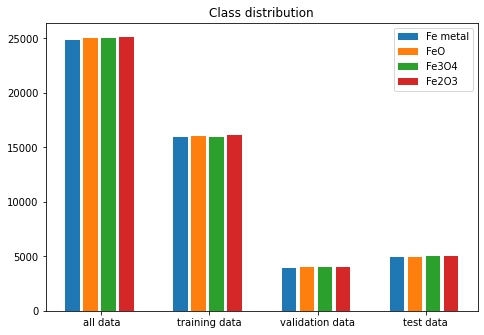

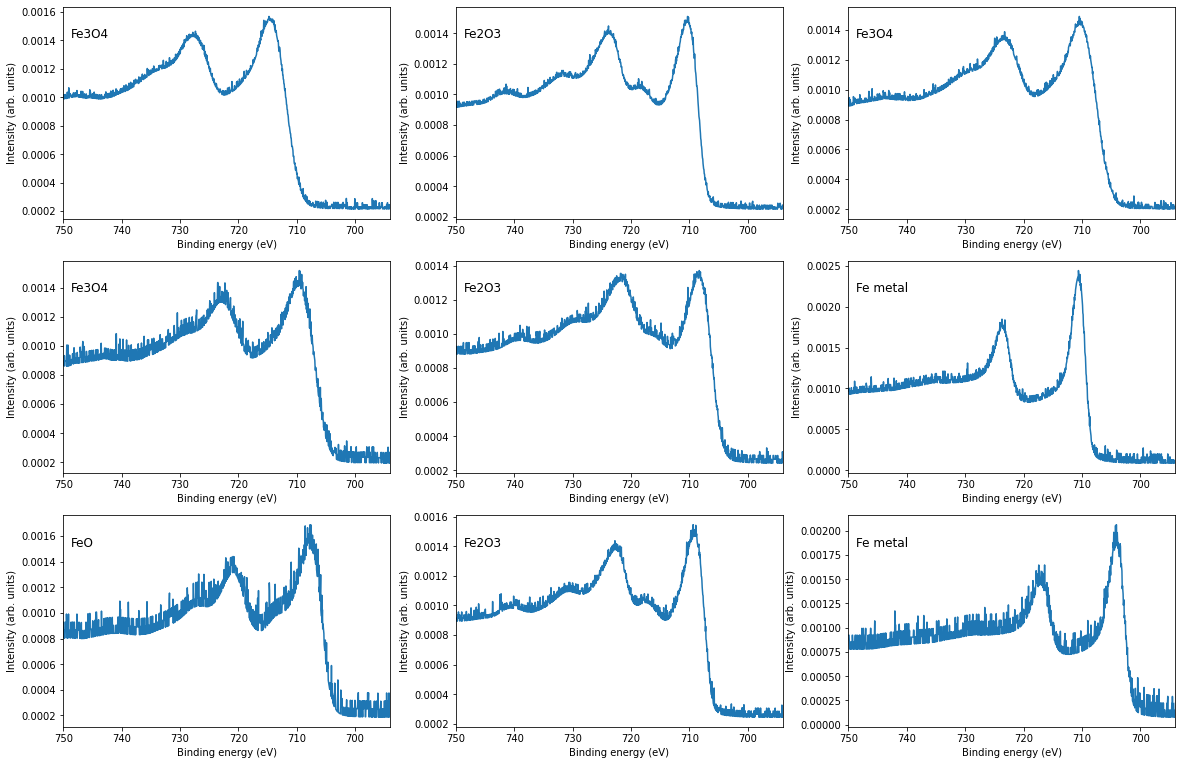

In [22]:
train_test_split = 0.2
train_val_split = 0.2
no_of_examples = 100000

X_train, X_val, X_test, y_train, y_val, y_test = \
        clf.load_data_preprocess(input_filepath = input_filepath,
                                 no_of_examples = no_of_examples,
                                 train_test_split = train_test_split,
                                 train_val_split = train_val_split)
        
# Check how the examples are distributed across the classes.
class_distribution = clf.check_class_distribution()
clf.plot_class_distribution()
clf.plot_random(no_of_spectra = 9, dataset = 'train')  

### Build the model

Model: "Custom_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 1113, 2)           20        
_________________________________________________________________
average_pooling1d (AveragePo (None, 556, 2)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 556, 2)            8         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 550, 2)            30        
_________________________________________________________________
average_pooling1d_1 (Average (None, 275, 2)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 275, 2)            8         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 269, 4)            6

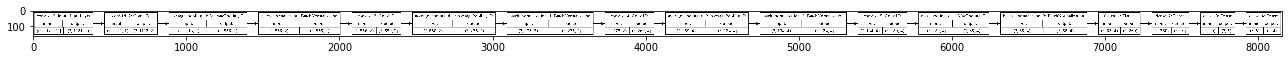

In [23]:
clf.build_model()
clf.summary()
clf.save_and_print_model_image()

### Training

In [24]:
epochs = 150
batch_size = 32

hist = clf.train(checkpoint = True,
                 early_stopping = False,
                 tb_log = True, 
                 csv_log = True,
                 epochs = epochs, 
                 batch_size = batch_size,
                 verbose = 1)

Train on 64000 samples, validate on 16000 samples
Epoch 1/150
63904/64000 [============================>.] - ETA: 0s - loss: 1.3768 - accuracy: 0.2464INFO:tensorflow:Assets written to: /content/drive/My Drive/app/saved_models/20200622_12h07m_Fe_single_4_classes_CNN/assets


AttributeError: ignored

### Graphs

In [ ]:
graph = TrainingGraphs(clf.history,
                        clf.model_name,
                        clf.time) 

### Evaluation on test data

In [ ]:
score = clf.evaluate()
test_loss, test_accuracy = score[0], score[1]
print('Test loss: ' + str(np.round(test_loss, decimals=3)))
print('Test accuracy: ' + str(np.round(test_accuracy, decimals=3)))

###  Prediction on test data

In [ ]:
pred_train, pred_test = clf.predict()
pred_train_classes, pred_test_classes = clf.predict_classes()

### Show some predictions

#### 5 random training samples

In [ ]:
clf.plot_random(no_of_spectra = 6, dataset = 'train', with_prediction = True)  

#### 5 random test samples

In [ ]:
clf.plot_random(no_of_spectra = 6, dataset = 'test', with_prediction = True)  

### Show wrong predictions

In [ ]:
clf.show_wrong_classification()

### Saving model and data

In [ ]:
clf.save_model()
clf.shelve_results(full = False)  

### Report

In [ ]:
dir_name = clf.time + '_' + clf.model_name
rep = Report(dir_name)  
rep.write()   

### Save output of notebook

In [ ]:
from IPython.display import Javascript, display
from nbconvert import HTMLExporter

def save_notebook():
    display(Javascript("IPython.notebook.save_notebook()"),
            include=['application/javascript'])

def output_HTML(read_file, output_file):
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

import time
import os

save_notebook()
time.sleep(10)
current_file = '/content/drive/My Drive/app/xpsdeeplearning/train_colab.ipynb'
output_file = os.path.join(clf.log_dir,'train_colab_out.html')
output_HTML(current_file, output_file)